<IPython.core.display.Javascript object>


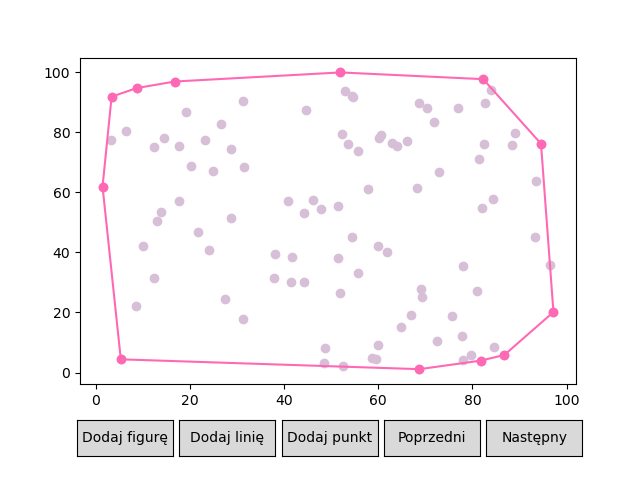

In [1]:
%run geometria.ipynb
%run Graham.ipynb # algorytm Grahama jest wykorzystywany w implementacji algorytmu Chana
import math

In [2]:
Tolerance = 10e-12

# Funkcje pomocnicze

In [9]:
# sprawdzanie, po której stronie odcinka leży punkt - funkcje pomocnicze
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - c[0] * b[1] - b[0] * a[1] - a[0] * c[1]

def orient(a, b, c):
    determinant = det(a, b, c)
    if determinant > Tolerance: # lewa strona
        return 1
    elif determinant < -Tolerance: # prawa strona
        return -1
    else:        # współliniowe
        return 0

# podział na k grup, w których jest co najwyżej m punktów
def group_points(points, m):
    n = len(points)
    k = math.ceil(n/m) # tyle jest wszystkich grup
    l = n // k # tyle punktów będzie po równo w każdej grupie
    groups = [[] for _ in range(k)]

    idx = 0
    group = 0  
    for curr_group in range(k):
        if idx + l - 1 < n:
            groups[curr_group] = points[idx:idx+l]
            idx += l
    
    while idx < n:
        groups[group].append(points[idx])
        idx += 1
        group += 1
        
    return groups

# szuka najniższego punktu (analogia do algorytmu Jarvisa) - zwraca indeks w tablicy otoczek
def find_lowest(hulls):
    point = hulls[0][0]
    x, y = 0, 0
    for k in range(len(hulls)):
        for i in range(len(hulls[k])):
            new_point = hulls[k][i]
            if  new_point[1] < point[1]:
                point = new_point
                x, y = k, i
    return x, y
            

# wyznaczanie stycznej
def tangent(point, hull):
    n = len(hull)
    l, r = 0, n - 1
    
    while l < r:
        mid = (l+r)//2
        # jeśli punkt pod indeksem left, right albo mid ma najmniejszy kąt to zwracam ten punk
        for elem in [l, mid, r]:
            if orient(point, hull[elem], hull[elem-1]) == 1 and orient(point, hull[elem], hull[(elem+1)%n]) == 1:   
                return elem
            
        # prawa widoczna, lewa nie    
        if orient(hull[l], hull[(l + 1) % n], point) != -1 and orient(hull[r], hull[(r + 1) % n], point) == -1:
            return (r + 1) % n
        
        # lewa widoczna, prawa nie lub obie widoczne
        elif orient(hull[l], hull[(l + 1) % n], point) == -1:
            if orient(hull[mid], hull[(mid + 1) % n], point) == -1:
                l = mid + 1
            elif orient(hull[mid], hull[(mid + 1) % n], point) != -1:
                r = mid - 1
                
        else:
            if orient(hull[mid], hull[(mid + 1) % n], point) == -1 or orient(point, hull[l], hull[mid]) == 1:
                l = mid + 1
            else:
                r = mid - 1
                
    return l

# szukanie kolejnego punktu otoczki

def next_point(subhulls, point):
    next_point = point[0], (point[1]+1) % len(subhulls[point[0]])
    x, y = point
    for k in range(len(subhulls)):
        if k != point[0]:
            t = tangent(subhulls[x][y], subhulls[k])
            a, b = next_point
            if t is not None and det(subhulls[x][y], subhulls[a][b], subhulls[k][t]) < Tolerance:
                if point != (k,t):
                    next_point = (k, t)
    return next_point

# wizualizacja algorytmu

def get_lines(hull):
    lines = []
    for i in range(len(hull)-1):
        lines.append((hull[i], hull[i+1]))
    lines.append((hull[-1], hull[0]))
    return lines

def add_scene(points, scenes, hull, point):
    lines = get_lines(hull)
    scenes.append(Scene(points=[PointsCollection(deepcopy(points), color="peachpuff"),
                               PointsCollection([point], color="cyan")],
                        lines=[LinesCollection(deepcopy(lines), color="coral"),
                               LinesCollection([(hull[-1], point)], color="cyan")]))
    
def visualize_hull(points, scenes, hull):
    lines = get_lines(hull)
    scenes.append(Scene(points=[PointsCollection(deepcopy(points), color="peachpuff")],
                        lines=[LinesCollection(deepcopy(lines), color="coral")]))
    
def visualize_subhulls(subhulls, points, scenes):
    points, lines = [PointsCollection(deepcopy(points), color="peachpuff")], []
    for hull in subhulls:
        curr_lines = get_lines(hull)
        lines.append(LinesCollection(deepcopy(curr_lines), color="coral"))
    scenes.append(Scene(points,lines))

# Główny algorytm

In [10]:
def Chan(points, m):
    scenes = [Scene(points=[PointsCollection(deepcopy(points), color="peachpuff")])]
    groups = group_points(points, m)
    k = len(groups)
    subhulls = [Graham_(groups[i]) for i in range(k)]
    visualize_subhulls(subhulls, points, scenes)
    x,y = find_lowest(subhulls)
    hull = [subhulls[x][y]]
    
    while True:
        
        for _ in range(m):
            next_ = next_point(subhulls, (x, y))
            x, y = next_
            point = subhulls[x][y]
            add_scene(points, scenes, hull, point)
            if point == hull[0]:
                visualize_hull(points, scenes, hull)
                return hull, scenes
            hull.append(point)
            
        m = min(m*m, len(points))
        
    return [], scenes


# Testowanie

<IPython.core.display.Javascript object>


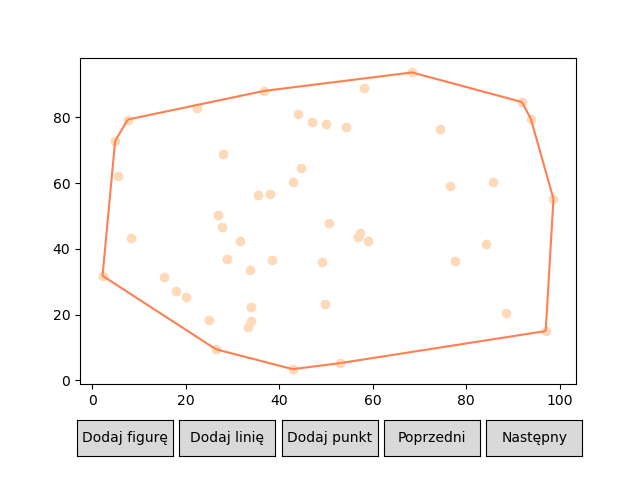

In [13]:
def generate_points(amount, low, high):
    a = np.random.rand(amount).astype(np.float64) * (high - low) + low
    b = np.random.rand(amount).astype(np.float64) * (high - low) + low
    return list(zip(a, b))

data = generate_points(50, 0, 100)
hull, scenes = Chan(data, 4)
plot = Plot(scenes=scenes)
plot.draw()

# Algorytm bez wizualizacji

In [11]:
def Chan_(points, m):
    groups = group_points(points, m)
    k = len(groups)
    subhulls = [Graham_(groups[i]) for i in range(k)]
    x,y = find_lowest(subhulls)
    hull = [subhulls[x][y]]
    
    while True:
        
        for _ in range(m):
            next_ = next_point(subhulls, (x, y))
            x, y = next_
            point = subhulls[x][y]
            if point == hull[0]:
                return hull
            hull.append(point)
            
        m = min(m*m, len(points))
        
    return []